# F4B101A / TP4 / Analyse de séries temporelles et modèles ARMA

*D'après le notebook IPython par P. Tandeo et T. Guilment.*  
Données : concentration hebdomadaire de CO2 mesurée à Hawaii entre 1974 et 2016 (ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt).

In [45]:
using DataFrames
using DSP
using Gadfly
using PyCall
@pyimport numpy as np

In [46]:
Y = readdlm("CO2.txt")[:,1]; # CO2 concentration (ppm)
time = linspace(1974.38, 2016.753, length(Y)); # Year (decimal)

xmin = minimum(time);
xmax = maximum(time);

df_raw = DataFrame(x=time, y=Y, ymin=Y, ymax=Y, f="raw data");

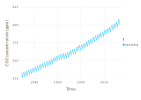

In [47]:
plot(df_raw, x=:x, y=:y, color=:f, Geom.line,
Coord.cartesian(xmin=xmin, xmax=xmax),
Guide.xlabel("Time"),
Guide.ylabel("CO2 concentration (ppm)"))

In [48]:
A = hcat(time.^2, time, ones(length(time)));
coeffs = A\Y;
T(X) = coeffs[1]*(X.^2) + coeffs[2]*X + coeffs[3];

df_tendancy = DataFrame(x=time, y=T(time), f="tendancy");

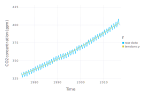

In [49]:
plot(vcat(df_raw, df_tendancy), x=:x, y=:y, color=:f, Geom.line,
Coord.cartesian(xmin=xmin, xmax=xmax),
Guide.xlabel("Time"),
Guide.ylabel("CO2 concentration (ppm)"))

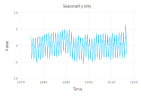

In [50]:
plot(x=time, y=Y-T(time), Geom.line,
Guide.xlabel("Time"),
Guide.ylabel("Value"),
Guide.title("Seasonality only"))

In [51]:
p = periodogram(Y-T(time), fs=52);

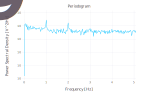

In [52]:
plot(x=p.freq, y=p.power, Geom.line,
Coord.cartesian(xmin=0, xmax=5),
Scale.y_log10,
Guide.xlabel("Frequency [Hz]"),
Guide.ylabel("Power Spectral Density [V^2/Hz]"),
Guide.title("Periodogram"))

$$S(t) = \beta_1 cos(2\pi\omega_1 t) + \beta_2 sin(2\pi\omega_1 t) + \beta_3 cos(2\pi\omega_2 t) + \beta_4 sin(2\pi\omega_2 t)$$

In [53]:
w1 = 1;
w2 = 2;

cosin(w,X) = cos(2*pi*w*X);
sinus(w,X) = sin(2*pi*w*X);

A = hcat(cosin(w1,time), sinus(w1,time), cosin(w2,time), sinus(w2,time));
coeffs_S = A\(Y-T(time));
S(X) = coeffs[1]*cosin(w1,X) + coeffs_S[2]*sinus(w1,X) + coeffs_S[3]*cosin(w2,X) + coeffs_S[4]*sinus(w2,X);

df_seasonality = DataFrame(x=time, y=T(time)+S(time), f="+ seasonality");

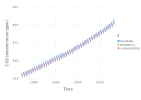

In [54]:
plot(vcat(df_raw, df_tendancy, df_seasonality), x=:x, y=:y, color=:f, Geom.line,
Coord.cartesian(xmin=xmin, xmax=xmax),
Guide.xlabel("Time"),
Guide.ylabel("CO2 concentration (ppm)"))

In [55]:
Z = Y-T(time)-S(time);

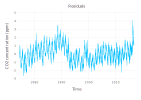

In [56]:
plot(x=time, y=Z, Geom.line,
Coord.cartesian(xmin=xmin, xmax=xmax),
Guide.xlabel("Time"),
Guide.ylabel("CO2 concentration (ppm)"),
Guide.title("Residuals"))

In [57]:
Z1 = Z[2:length(Z)];   # Z(t)
Z2 = Z[1:length(Z)-1]; # Z(t-1);

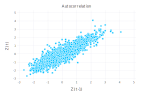

In [58]:
plot(x=Z2, y=Z1,
Guide.xlabel("Z(t-1)"),
Guide.ylabel("Z(t)"),
Guide.title("Autocorrelation"))

In [59]:
# fit AR(1)
reg_AR_1 = np.corrcoef(Z1, Z2);
phi = reg_AR_1[2];

# define the final residuals epsilon (stationary)
epsilon = Z2-(phi*Z1);

# compute var[Z(t+h)]
sigma2 = var(epsilon)
function compute_var_Z(sigma2, phi, h)
    res = 0
    for k = 1:h
        res += sigma2*phi^(2*k)
    end
    return res
end;

In [60]:
# mean forecasts
n_future = 10*52; # 10 years with 52 weeks
time_future = linspace(2016.753, 2026.753, n_future);
Y_future = T(time_future)+S(time_future);

# error forecasts
var_Z = Array{Float64}(0);
for h = 1:n_future
    var_Z = vcat(var_Z, compute_var_Z(sigma2, phi, h+1))
end

# 95% confidence = 1.96
conf = 1.96*sqrt(var_Z);

df_future = DataFrame(
x=time_future, y=Y_future,
ymin=Y_future - conf,
ymax=Y_future + conf,
f="forecast"
);

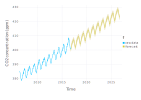

In [61]:
plot(vcat(df_raw, df_future), x=:x, y=:y, ymin=:ymin, ymax=:ymax, color=:f, Geom.line, Geom.ribbon,
Coord.cartesian(xmin=2006.753, xmax=2026.753, ymin=380, ymax=430),
Guide.xlabel("Time"),
Guide.ylabel("CO2 concentration (ppm)"))